<a href="https://colab.research.google.com/github/mohamedhasssan/global-food-price-analysis/blob/main/anomaly_detection_and_analytical_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 3 – Anomaly Detection and Analytical Metrics
### Global Food Price Anomaly Analysis

## Notebook Purpose
This notebook implements the anomaly detection and volatility metrics necessary to identify unusual movements in global food price indices.

### Objectives
- Load cleaned long-format dataset from Sprint 2
- Compute baseline statistical diagnostics
- Create rolling mean and rolling volatility metrics
- Define anomaly thresholds per commodity
- Produce anomaly flags
- Visualize anomalies
- Generate summary tables that will support consulting-level insights


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = "https://raw.githubusercontent.com/mohamedhasssan/global-food-price-analysis/refs/heads/main/data/food_price_clean_long.csv"
df_long = pd.read_csv(url, parse_dates=['date'])


## Background – Understanding Global Food Commodity Dynamics

Before interpreting price behaviour, it is necessary to understand the basic drivers of global food commodities.

### Food Price Index (FPI)
A composite index published by FAO that tracks international prices of a basket of food commodities. It reflects overall global food inflation.

### Key Commodity Dynamics
- **Oils**: Highly sensitive to energy markets, biodiesel demand, and geopolitical disruptions.
- **Cereals**: Influenced by weather patterns, global crop yields, and trade policies.
- **Dairy**: Affected by feed costs, production cycles, and supply chain issues.
- **Meat**: Relatively stable due to slower production cycles and consistent demand.
- **Sugar**: Generally stable but vulnerable to extreme weather events in producing regions.


In [95]:
summary = df_long.groupby('commodity')['index_value'].describe()
summary


,count,mean,std,min,25%,50%,75%,max
commodity,,,,,,,,
cereals,431.0,89.586543,31.630097,48.60,60.600,88.30,111.700,173.5
dairy,431.0,88.591415,34.968928,36.80,57.500,81.70,117.200,158.2
food_price_index,431.0,89.034107,27.204357,50.80,64.650,87.00,116.350,160.2
meat,431.0,87.364733,18.450267,52.30,73.400,85.10,101.250,128.1
oils,431.0,93.550209,39.863284,35.83,63.895,83.17,120.485,251.8
sugar,431.0,84.901624,32.764073,31.80,60.100,78.70,108.400,183.2


<Axes: xlabel='commodity'>

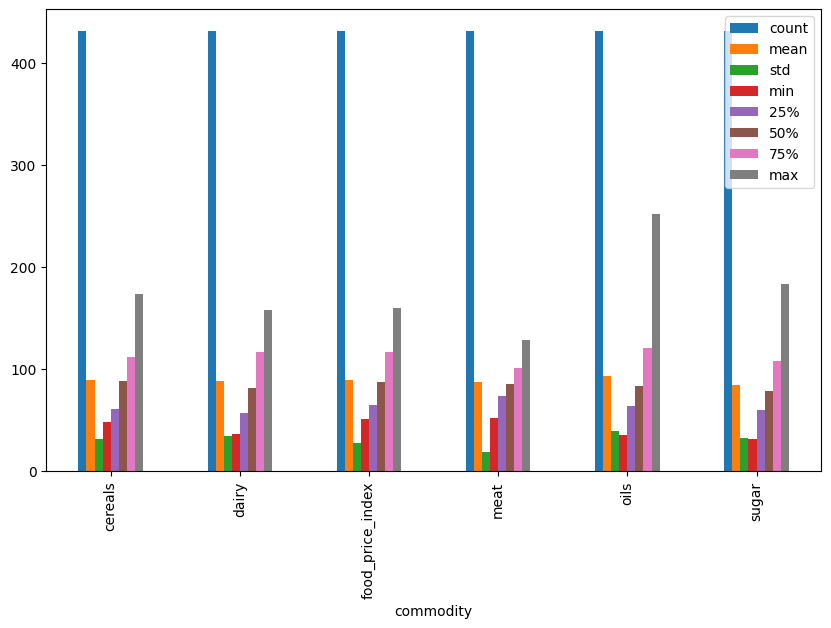

In [96]:
summary.plot(kind='bar', figsize=(10, 6))

### Interpretation
The descriptive statistics show clear volatility patterns across global food commodities.


1.   Oils Exhibit the highest volatility with the widest rage between minimum and maximum values and the largest standard deviation. Based on domain knowledge this indicates disruptions in the energy markets and geopolitical disruptions.
2.   Cereals, Dairy and Sugar have medium to high volatility showing effects due to weather, supply chain issues and trade policies
3.  Meat is the most stable of the commodities showing consistent demand vs production.
4.  Overall food_price_index show combined volatility but is potentially affected more by inflation cycles and larger supply chain issues like war and pandemics.




## Monthly Percent Change Metric

In [97]:
df_long['pct_change'] = (
    df_long.groupby('commodity')['index_value'].pct_change() * 100
)
df_long.head()


,date,commodity,index_value,pct_change
0,1990-01-01,food_price_index,64.4,NaN
1,1990-02-01,food_price_index,64.7,0.465839
2,1990-03-01,food_price_index,64.0,-1.081917
3,1990-04-01,food_price_index,66.0,3.125000
4,1990-05-01,food_price_index,64.6,-2.121212


## Rolling Mean and Rolling Standard Deviation

In [98]:
df_long['roll_mean_3']=df_long.groupby('commodity')['index_value'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_long['roll_std_3']=df_long.groupby('commodity')['index_value'].transform(lambda x: x.rolling(window=3, min_periods=1).std())

In [99]:
df_long.head()

,date,commodity,index_value,pct_change,roll_mean_3,roll_std_3
0,1990-01-01,food_price_index,64.4,NaN,64.400000,NaN
1,1990-02-01,food_price_index,64.7,0.465839,64.550000,0.212132
2,1990-03-01,food_price_index,64.0,-1.081917,64.366667,0.351188
3,1990-04-01,food_price_index,66.0,3.125000,64.900000,1.014889
4,1990-05-01,food_price_index,64.6,-2.121212,64.866667,1.026320


## Define Anomaly Thresholds

In [100]:
df_long['upper_bound'] = df_long['roll_mean_3'] + 1.152 * df_long['roll_std_3']
df_long['lower_bound'] = df_long['roll_mean_3'] - 1.152 * df_long['roll_std_3']

df_long['anomaly']=(
    (df_long['index_value'] > df_long['upper_bound']) |
    (df_long['index_value'] < df_long['lower_bound'])

)

In [101]:
df_long.head()

,date,commodity,index_value,pct_change,roll_mean_3,roll_std_3,upper_bound,lower_bound,anomaly
0,1990-01-01,food_price_index,64.4,NaN,64.400000,NaN,NaN,NaN,False
1,1990-02-01,food_price_index,64.7,0.465839,64.550000,0.212132,64.794376,64.305624,False
2,1990-03-01,food_price_index,64.0,-1.081917,64.366667,0.351188,64.771236,63.962098,False
3,1990-04-01,food_price_index,66.0,3.125000,64.900000,1.014889,66.069152,63.730848,False
4,1990-05-01,food_price_index,64.6,-2.121212,64.866667,1.026320,66.048988,63.684346,False


## Plotting Template for Anomalies

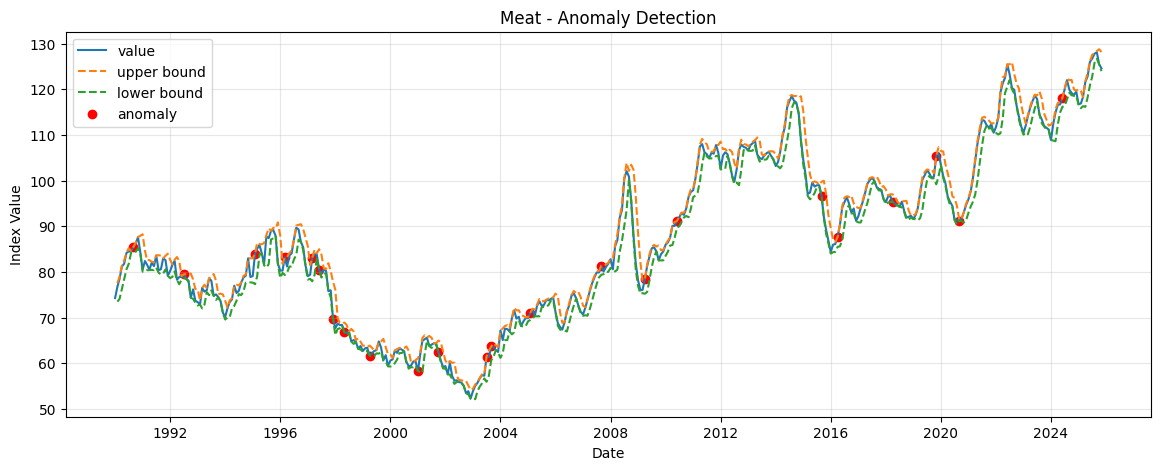

In [102]:
commodity = "meat"  # change to any commodity

subset = df_long[df_long['commodity'] == commodity]

plt.figure(figsize=(14,5))
plt.plot(subset['date'], subset['index_value'], label='value')
plt.plot(subset['date'], subset['upper_bound'], linestyle='--', label='upper bound')
plt.plot(subset['date'], subset['lower_bound'], linestyle='--', label='lower bound')

# plot anomalies
anoms = subset[subset['anomaly']]
plt.scatter(anoms['date'], anoms['index_value'], color='red', label='anomaly')

plt.title(f"{commodity.capitalize()} - Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Plotting: food_price_index


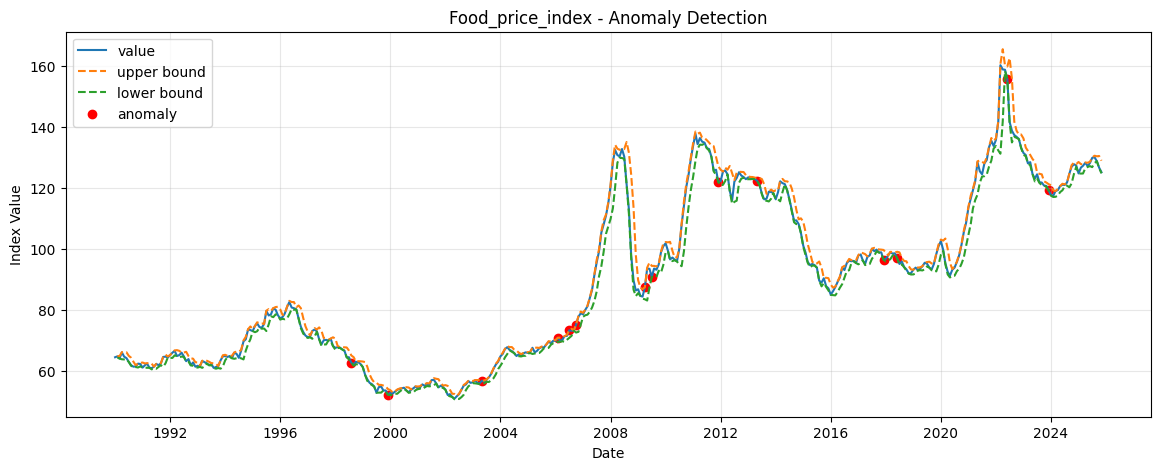

Plotting: meat


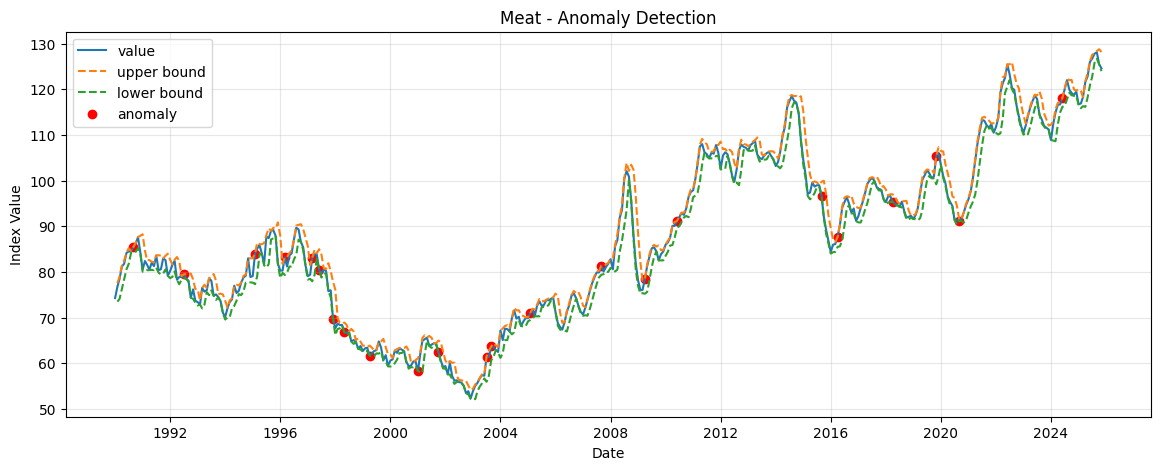

Plotting: dairy


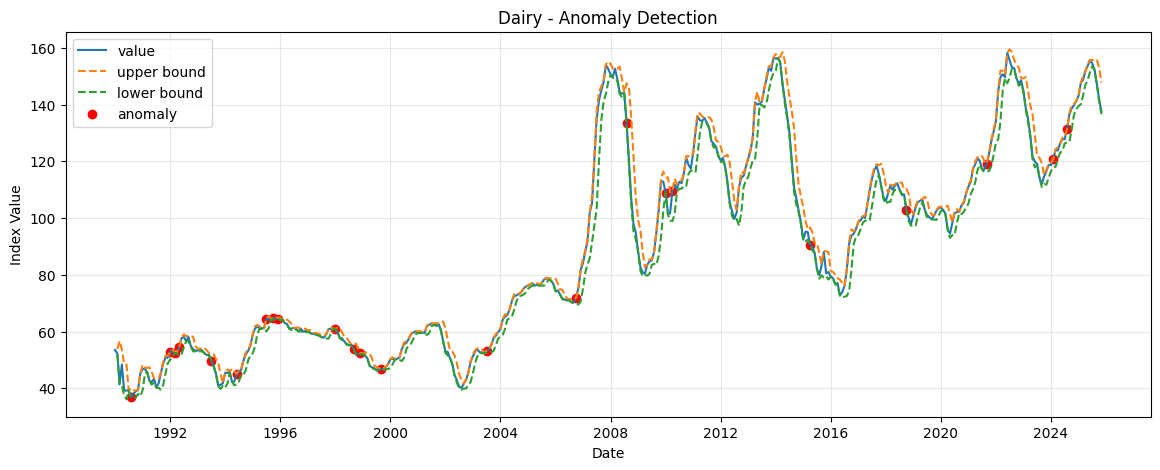

Plotting: cereals


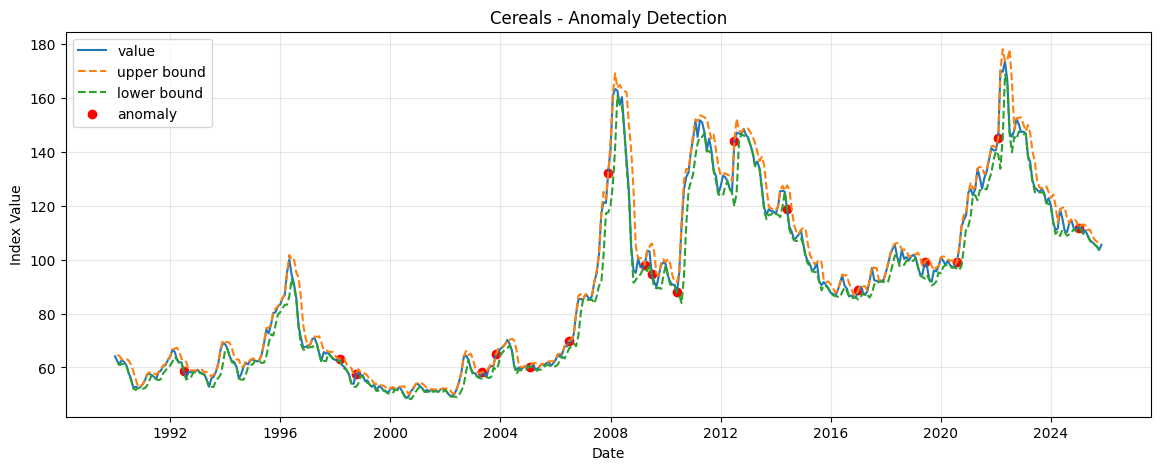

Plotting: oils


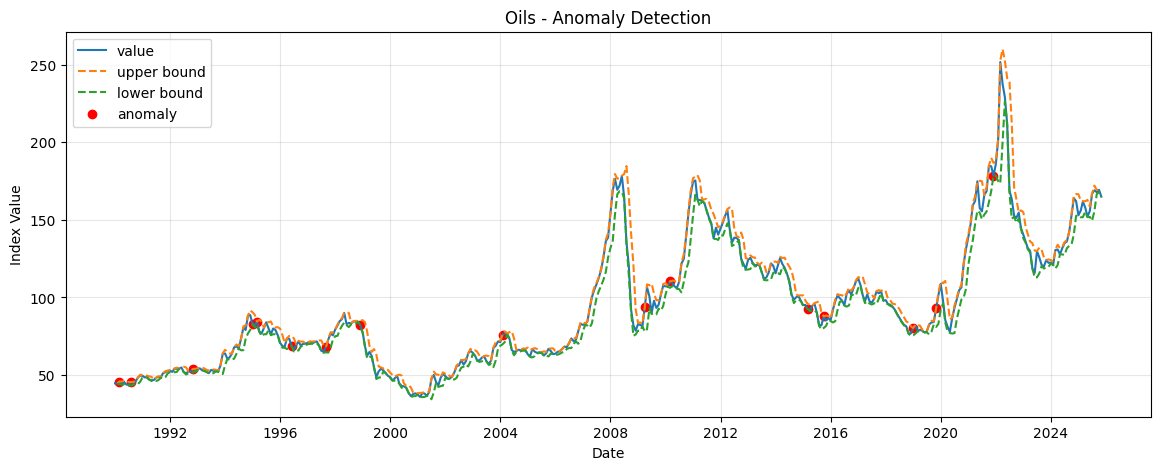

Plotting: sugar


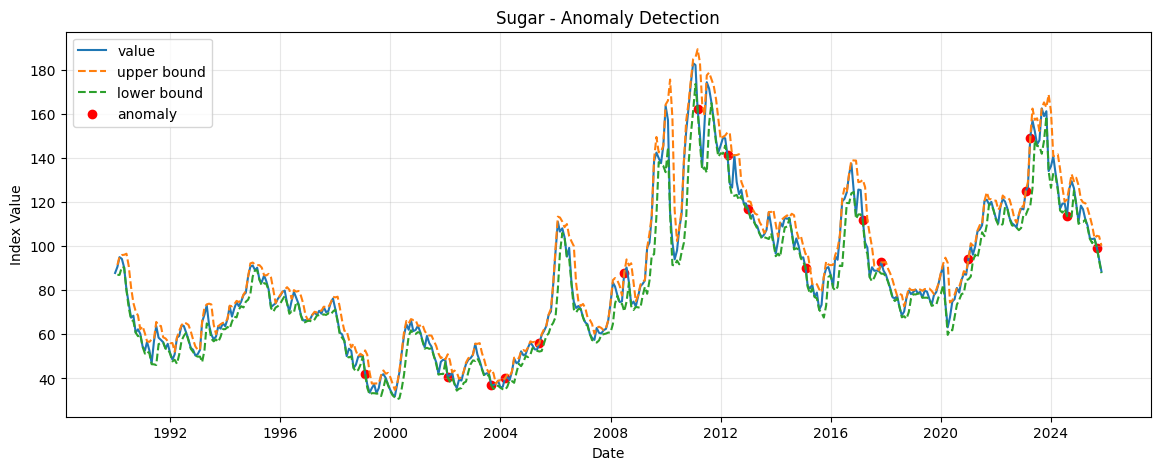

In [103]:
for c in df_long['commodity'].unique():
    print("Plotting:", c)
    subset = df_long[df_long['commodity'] == c]

    plt.figure(figsize=(14,5))
    plt.plot(subset['date'], subset['index_value'], label='value')
    plt.plot(subset['date'], subset['upper_bound'], linestyle='--', label='upper bound')
    plt.plot(subset['date'], subset['lower_bound'], linestyle='--', label='lower bound')

    anoms = subset[subset['anomaly']]
    plt.scatter(anoms['date'], anoms['index_value'], color='red', label='anomaly')

    plt.title(f"{c.capitalize()} - Anomaly Detection")
    plt.xlabel("Date")
    plt.ylabel("Index Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## Anomaly Counts per commodity

In [104]:
anomaly_summary = df_long.groupby('commodity')['anomaly'].sum()
anomaly_summary


,anomaly
commodity,
cereals,18
dairy,23
food_price_index,14
meat,23
oils,16
sugar,17


### Interpretation

The z score value of 1.152 produces significant anomalies across commodities. it produced enough positives to consider and move forward. Dairy and mean seems to have the highest anomalies shown which is in line with supply chain disruptions due to diseases and other factors. Sugar, oil and cereals are moderate between 16 and 18 anomalies reflecting periodic market shocks. The composite foo price index shows 14 anomalies consistent with the smoothing effects of aggregating the other commodities. This threshhold identifies meaningful deviations while avoiding over triggering.

## Months with the most anomalies

| year_month   |   0 |
|:-------------|----:|
| 2009-04      |   4 |
| 1992-07      |   2 |
| 1990-08      |   2 |
| 2003-09      |   2 |
| 2019-11      |   2 |
| 2024-08      |   2 |
| 1998-12      |   2 |
| 2005-02      |   2 |
| 2009-07      |   2 |
| 2006-07      |   2 |
| 2006-10      |   2 |
| 2003-07      |   2 |
| 2003-05      |   2 |
| 2010-06      |   2 |
| 1990-09      |   1 |

In [105]:
# Count anomalies per month across all commodities
df_long['year_month'] = df_long['date'].dt.to_period('M')

monthly_anomalies = df_long[df_long['anomaly']].groupby('year_month').size().sort_values(ascending=False)
monthly_anomalies.head(15)


,0
year_month,
2009-04,4
1992-07,2
1990-08,2
2003-09,2
2019-11,2
2024-08,2
1998-12,2
2005-02,2
2009-07,2


## Interpretation

2009 April has the highest concentration of anomalies.

In [106]:
## Function for plotting commodities

import matplotlib.pyplot as plt

def plot_commodity(commodity):
    subset = df_long[df_long['commodity'] == commodity].sort_values('date')

    plt.figure(figsize=(14, 6))
    plt.plot(subset['date'], subset['index_value'], label='value')
    plt.plot(subset['date'], subset['upper_bound'], linestyle='--', label='upper bound')
    plt.plot(subset['date'], subset['lower_bound'], linestyle='--', label='lower bound')

    anoms = subset[subset['anomaly']]
    plt.scatter(anoms['date'], anoms['index_value'], color='red', label='anomaly')

    plt.title(f"{commodity.capitalize()} – Price Trend and Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Index value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f"{commodity}_anomalies.png", dpi=1000)
    plt.show()


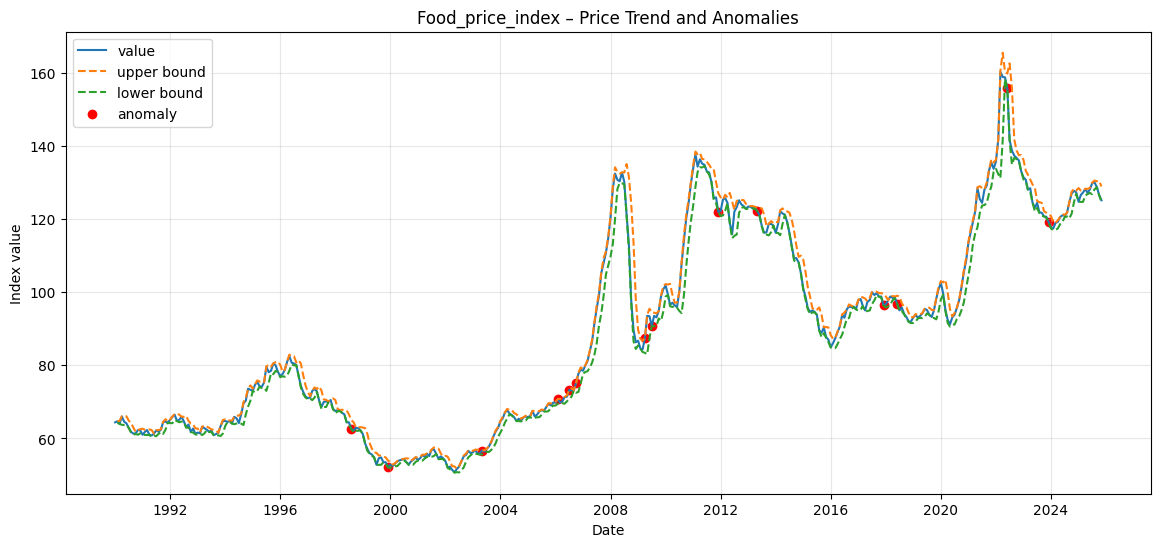

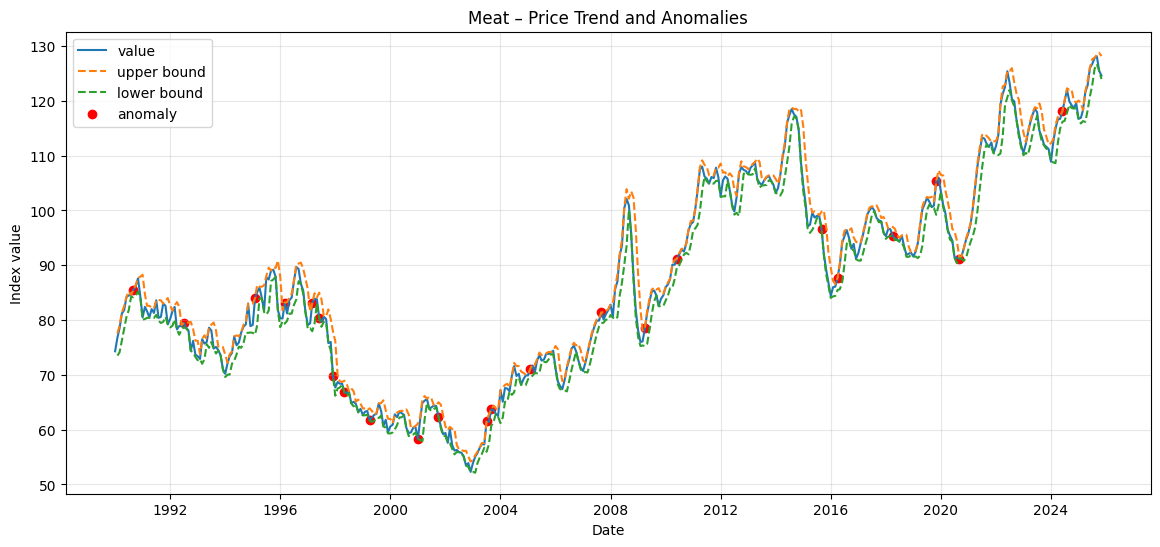

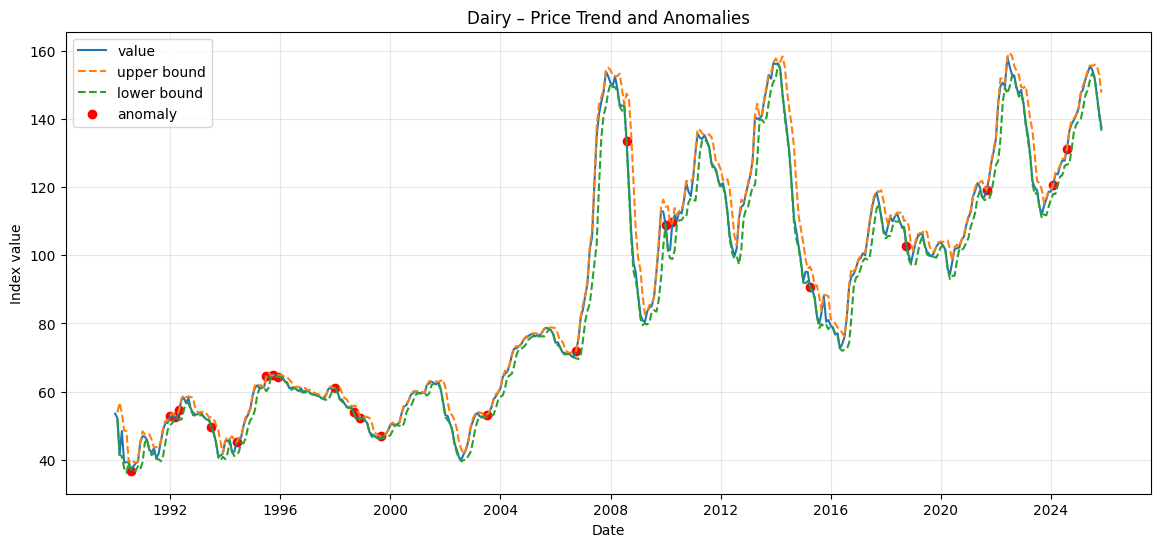

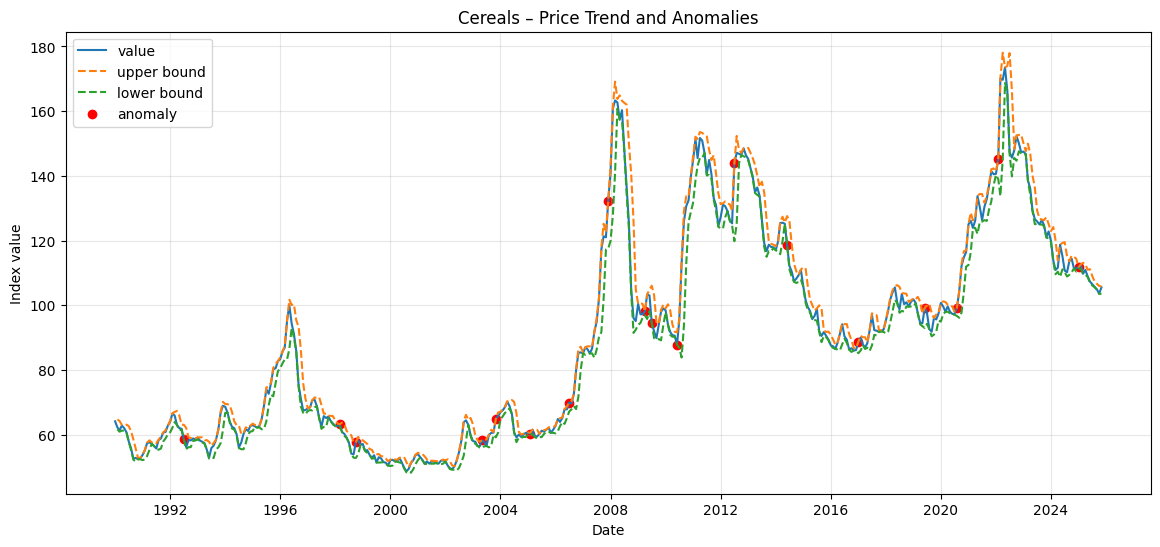

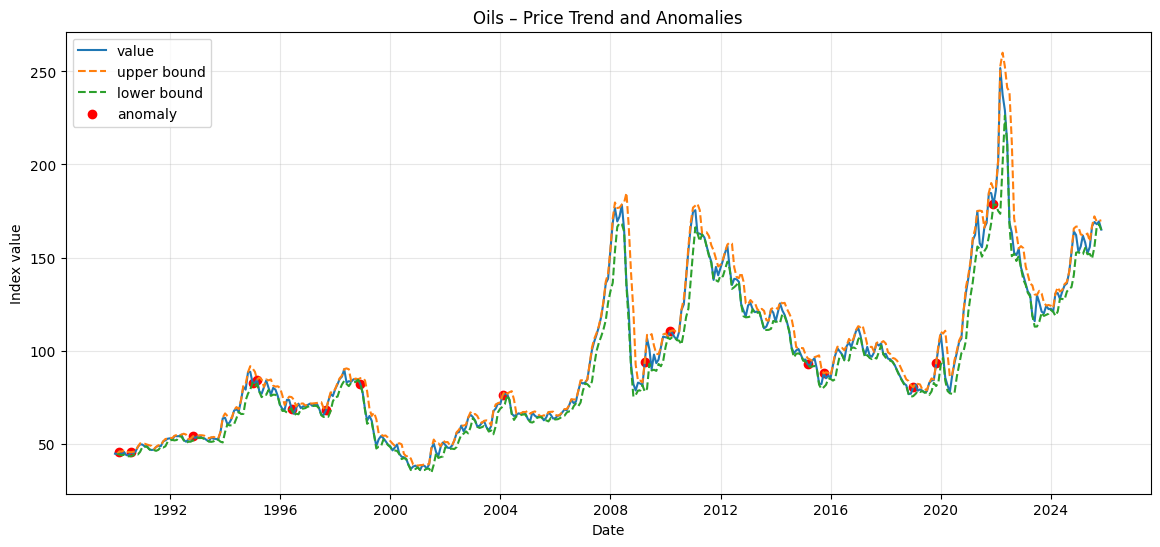

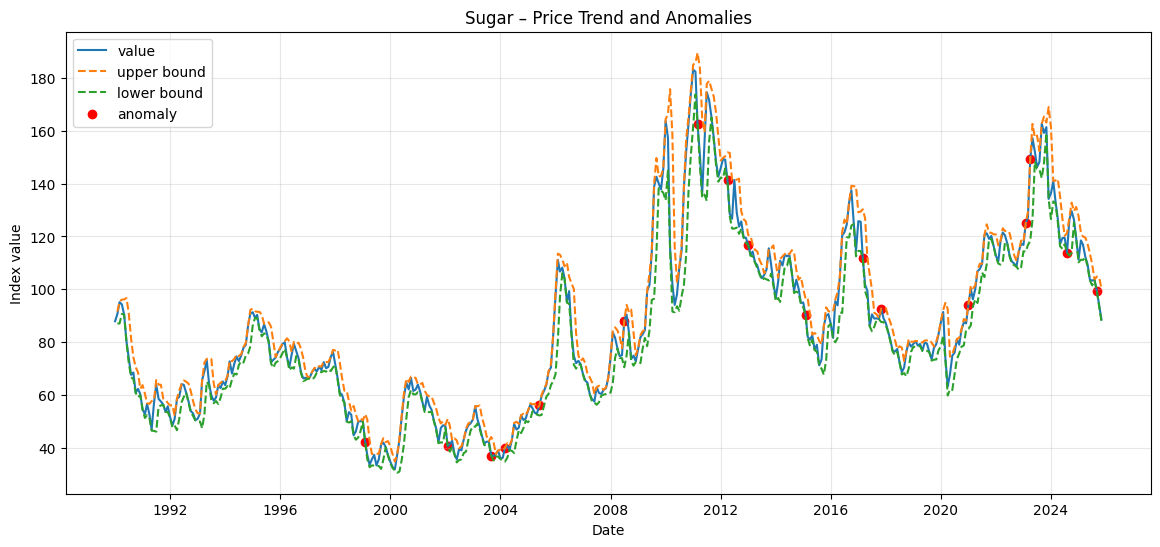

In [107]:
for c in df_long['commodity'].unique():
    plot_commodity(c)


## Cross-Commodity Comparison Summary


In [108]:
cross_summary = (
    df_long
    .groupby('commodity')
    .agg(
        mean_index=('index_value', 'mean'),
        std_index=('index_value', 'std'),
        anomaly_count=('anomaly', 'sum')
    )
    .sort_values('std_index', ascending=False)
)

cross_summary


,mean_index,std_index,anomaly_count
commodity,,,
oils,93.550209,39.863284,16
dairy,88.591415,34.968928,23
sugar,84.901624,32.764073,17
cereals,89.586543,31.630097,18
food_price_index,89.034107,27.204357,14
meat,87.364733,18.450267,23


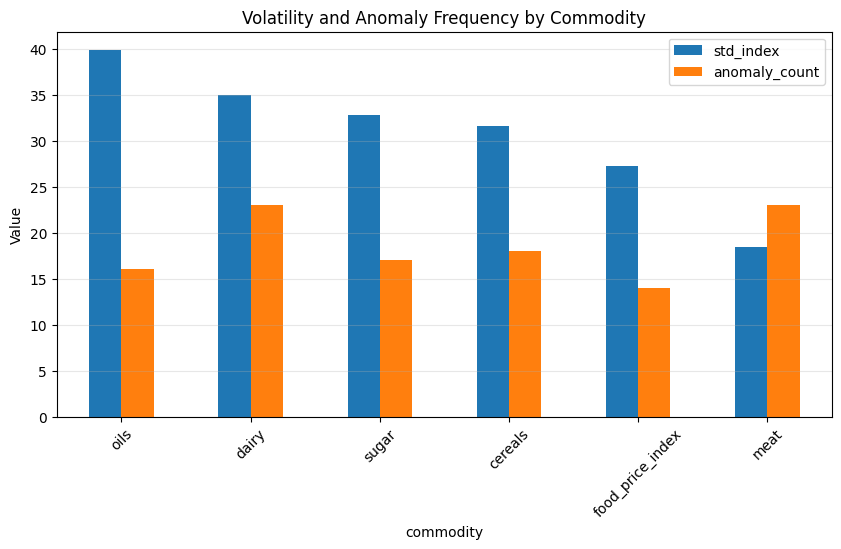

In [109]:
cross_summary[['std_index', 'anomaly_count']].plot(kind='bar', figsize=(10,5))
plt.title("Volatility and Anomaly Frequency by Commodity")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


## Executive Insight Summary (Sprint 4)

1. Commodity groups exhibit distinct volatility profiles. Oils display the highest overall volatility, indicating persistent instability rather than isolated shock events.

2. Dairy combines high volatility with frequent anomalies, suggesting recurring short-term disruptions rather than smooth price fluctuations.

3. Meat prices remain structurally stable but show a high number of anomalies, indicating infrequent yet meaningful deviations from long-term trends.

4. Sugar demonstrates moderate volatility with episodic anomalies, consistent with a generally stable market punctuated by occasional shocks.

5. The composite Food Price Index shows both lower volatility and fewer anomalies, confirming its role as a smoothed, system-level indicator that absorbs individual commodity shocks.


## SEVERITY OF ANOMALY

Rolling period changed to 6 months for mean and 24 months for standard deviation to provide decision makers with clear bands of decision making. this new period chosen ensures that the anomalies are based on real trends and account for all forms of volatility and spread but also see the severity on a longer scale view.


In [110]:
# Ensure sorted
df_long = df_long.sort_values(['commodity', 'date']).copy()

# Rolling mean for "expected" value (6 months)
df_long['mean_6m'] = df_long.groupby('commodity')['index_value'].transform(
    lambda x: x.rolling(window=6, min_periods=6).mean()
)

# Rolling std for normalization (24 months)
df_long['std_24m'] = df_long.groupby('commodity')['index_value'].transform(
    lambda x: x.rolling(window=24, min_periods=24).std()
)

# z-score (can be NaN for early periods until windows are filled)
df_long['z_6m_24m'] = (df_long['index_value'] - df_long['mean_6m']) / df_long['std_24m']

# Severity magnitude + direction
df_long['severity'] = df_long['z_6m_24m'].abs()
df_long['direction'] = np.where(df_long['z_6m_24m'] >= 0, 'Up', 'Down')


In [111]:
# Per-commodity elevated threshold at top 5%
elev_thr = df_long.groupby('commodity')['severity'].quantile(0.95)
elev_thr.name = 'elev_thr'
elev_thr


,elev_thr
commodity,
cereals,1.485947
dairy,1.375570
food_price_index,1.468526
meat,1.564337
oils,1.547653
sugar,1.545176


In [112]:
thr_95 = df_long.groupby('commodity')['severity'].quantile(0.95).rename('thr_95')
thr_975 = df_long.groupby('commodity')['severity'].quantile(0.975).rename('thr_975')
thr_99  = df_long.groupby('commodity')['severity'].quantile(0.99).rename('thr_99')

df_long = df_long.merge(thr_95, left_on='commodity', right_index=True, how='left')
df_long = df_long.merge(thr_975, left_on='commodity', right_index=True, how='left')
df_long = df_long.merge(thr_99,  left_on='commodity', right_index=True, how='left')

def band(row):
    s = row['severity']
    if pd.isna(s):
        return np.nan
    if s >= row['thr_99']:
        return 'Extreme'
    if s >= row['thr_975']:
        return 'Severe'
    if s >= row['thr_95']:
        return 'Elevated'
    return 'Normal'

df_long['severity_band'] = df_long.apply(band, axis=1)


In [113]:
df_long.head()

,date,commodity,index_value,pct_change,roll_mean_3,roll_std_3,upper_bound,lower_bound,anomaly,year_month,mean_6m,std_24m,z_6m_24m,severity,direction,thr_95,thr_975,thr_99,severity_band
1293,1990-01-01,cereals,64.1,NaN,64.100000,NaN,NaN,NaN,False,1990-01,NaN,NaN,NaN,NaN,Down,1.485947,1.881192,2.44579,NaN
1294,1990-02-01,cereals,62.2,-2.964119,63.150000,1.343503,64.697715,61.602285,False,1990-02,NaN,NaN,NaN,NaN,Down,1.485947,1.881192,2.44579,NaN
1295,1990-03-01,cereals,61.3,-1.446945,62.533333,1.429452,64.180062,60.886605,False,1990-03,NaN,NaN,NaN,NaN,Down,1.485947,1.881192,2.44579,NaN
1296,1990-04-01,cereals,62.8,2.446982,62.100000,0.754983,62.969741,61.230259,False,1990-04,NaN,NaN,NaN,NaN,Down,1.485947,1.881192,2.44579,NaN
1297,1990-05-01,cereals,62.0,-1.273885,62.033333,0.750555,62.897973,61.168694,False,1990-05,NaN,NaN,NaN,NaN,Down,1.485947,1.881192,2.44579,NaN


In [118]:
df_long['severity_band'].value_counts()

,count
severity_band,
Normal,2322
Elevated,60
Severe,36
Extreme,30


In [119]:
df_long = df_long.sort_values(['commodity', 'date']).copy()

df_long['elev_plus'] = df_long['severity_band'].isin(['Elevated', 'Severe', 'Extreme'])


In [120]:
def assign_episode_ids(g, gap_tolerance=1):
    g = g.sort_values('date').copy()

    episode_id = 0
    gap = 0
    ids = []

    for active in g['elev_plus'].fillna(False).tolist():
        if active:
            if episode_id == 0:
                episode_id = 1
            gap = 0
            ids.append(episode_id)
        else:
            if episode_id == 0:
                ids.append(0)
            else:
                gap += 1
                if gap <= gap_tolerance:
                    ids.append(episode_id)
                else:
                    episode_id += 1
                    gap = 0
                    ids.append(0)

    g['episode_id'] = ids
    return g

df_long = (
    df_long.groupby('commodity', group_keys=False)
           .apply(assign_episode_ids, gap_tolerance=1)
)


/tmp/ipython-input-1021872401.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(assign_episode_ids, gap_tolerance=1)


In [121]:
# episode length in months (count rows assigned to that episode_id, excluding 0)
episode_lengths = (
    df_long[df_long['episode_id'] > 0]
    .groupby(['commodity', 'episode_id'])
    .size()
    .rename('episode_len')
    .reset_index()
)

df_long = df_long.merge(episode_lengths, on=['commodity', 'episode_id'], how='left')

def persistence_type(n):
    if pd.isna(n):
        return np.nan
    if n == 1:
        return 'Shock'
    if 2 <= n <= 3:
        return 'Disturbance'
    return 'Regime'

df_long['persistence_type'] = df_long['episode_len'].apply(persistence_type)


In [122]:
df_long['episode_id'].value_counts().head()


,count
episode_id,
0,1356
1,20
77,14
29,13
71,12


In [123]:
df_long[df_long['commodity']=='oils'][['date','severity_band','elev_plus','episode_id','episode_len','persistence_type']].tail(40)


,date,severity_band,elev_plus,episode_id,episode_len,persistence_type
2115,2022-08-01,Normal,False,161,1.0,Shock
2116,2022-09-01,Normal,False,0,NaN,NaN
2117,2022-10-01,Normal,False,162,1.0,Shock
2118,2022-11-01,Normal,False,0,NaN,NaN
2119,2022-12-01,Normal,False,163,1.0,Shock
2120,2023-01-01,Normal,False,0,NaN,NaN
2121,2023-02-01,Normal,False,164,1.0,Shock
2122,2023-03-01,Normal,False,0,NaN,NaN
2123,2023-04-01,Normal,False,165,1.0,Shock
2124,2023-05-01,Normal,False,0,NaN,NaN


In [124]:
(df_long[df_long['episode_id'] > 0]
 .drop_duplicates(['commodity','episode_id'])
 .groupby('persistence_type')
 .size()
 .sort_values(ascending=False)
)


,0
persistence_type,
Shock,1015
Disturbance,36
Regime,24


In [125]:
df_long[df_long['commodity']=='oils'][['date','severity_band','elev_plus','episode_id','episode_len','persistence_type']].tail(40)


,date,severity_band,elev_plus,episode_id,episode_len,persistence_type
2115,2022-08-01,Normal,False,161,1.0,Shock
2116,2022-09-01,Normal,False,0,NaN,NaN
2117,2022-10-01,Normal,False,162,1.0,Shock
2118,2022-11-01,Normal,False,0,NaN,NaN
2119,2022-12-01,Normal,False,163,1.0,Shock
2120,2023-01-01,Normal,False,0,NaN,NaN
2121,2023-02-01,Normal,False,164,1.0,Shock
2122,2023-03-01,Normal,False,0,NaN,NaN
2123,2023-04-01,Normal,False,165,1.0,Shock
2124,2023-05-01,Normal,False,0,NaN,NaN


In [126]:
df_long['episode_id'].value_counts().head()


,count
episode_id,
0,1356
1,20
77,14
29,13
71,12
